In [5]:
import os
import glob
import json
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

# Learning Rate

In [6]:
EXPERIMENT_TOTEST = "panasonic-hyper-0.0.4"
test_results = pd.read_csv(f"..//logs//{EXPERIMENT_TOTEST}//test_results.csv")

In [7]:
# Append learning rate to test results
lr_dfs = []
hyper_folders = glob.glob(f"..//logs//{EXPERIMENT_TOTEST}//train_*")[0]
for trial_folder in glob.glob(f"{hyper_folders}//trial_*"):
    with open(f"{trial_folder}//params.json", "r") as f:
        lr = json.load(f)["lr"]
        trial_name = os.path.basename(trial_folder)
        lr_dfs += [pd.DataFrame([{"trial": trial_name, "lr": lr}])]
merged_df = pd.merge(test_results, pd.concat(lr_dfs), on='trial')

In [8]:
merged_df

,trial,0degC,-10degC,-20degC,10degC,25degC,Average_MAE,lr
0,trial_d1265_00000,1.920,2.588,3.651,1.727,1.405,2.2582,0.000021
1,trial_d1265_00001,1.344,2.170,1.771,1.198,0.932,1.4830,0.000186
2,trial_d1265_00002,1.874,2.376,3.162,1.690,1.567,2.1338,0.000009
3,trial_d1265_00003,1.595,2.173,2.170,1.281,1.149,1.6736,0.000028
4,trial_d1265_00004,2.567,3.868,6.726,2.719,3.100,3.7960,0.000005
...,...,...,...,...,...,...,...,...
95,trial_d1265_00095,1.377,2.198,1.778,1.281,0.959,1.5186,0.000113
96,trial_d1265_00096,0.732,2.778,1.261,0.711,0.587,1.2138,0.003126
97,trial_d1265_00097,1.167,2.022,1.479,0.847,0.627,1.2284,0.000666
98,trial_d1265_00098,1.189,2.096,1.369,0.916,0.747,1.2634,0.001193


In [27]:
optim = merged_df[merged_df["Average_MAE"] == min(merged_df["Average_MAE"])]
optim_lr = optim["lr"]
optim_lr

42    0.005374
Name: lr, dtype: float64

In [29]:
optim

,trial,0degC,-10degC,-20degC,10degC,25degC,Average_MAE,lr
42,trial_d1265_00042,0.701,2.433,1.158,0.671,0.521,1.0968,0.005374


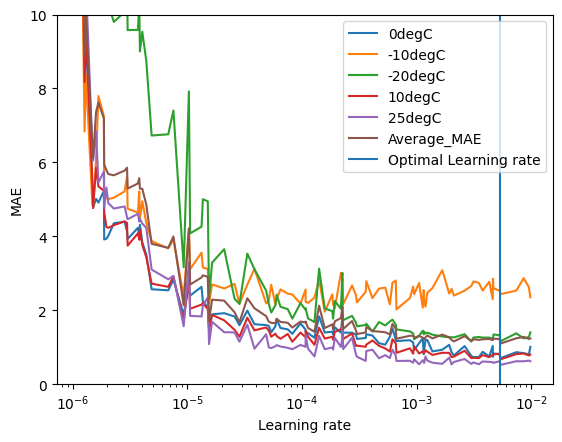

In [28]:
cols = ["0degC", "-10degC", "-20degC", "10degC", "25degC", "Average_MAE"]

for col in cols:
    merged_df = merged_df.sort_values(by='lr', ascending=True)
    plt.plot(merged_df["lr"], merged_df[col], label=col)
    plt.xlabel("Learning rate")
    plt.ylabel("MAE")
    plt.xscale("log")
    plt.ylim(0, 10)
plt.axvline(x = float(optim_lr), label = 'Optimal Learning rate')
plt.legend(loc='upper right')
plt.show()